# Projeto Final - Grandes dados para a Gestão (Mestrado MCDE 2023/2024)

## PySpark ML Fraud Detection

> Este projeto tem por escopo o desenvolvimento de um Pipeline de Machine Learning com uso do Spark.
<br>
<br>
> É necessário que sejam satisfeitas as etapas de feature engineering, criação do pipeline e treino/avaliação do modelo desenvolvido.
<br>
<br>
> Para tanto, deve ser utilizado o Data Set "Credit Card Fraud Detection", tendo como principal objetivo prever com a maior acurácia possível o target, que neste caso é a variável binária "Class".

<br>
CLASS PODE ASSUMIR OS SEGUINTES VALORES:

| Class | Valor de Referência   |
|-------|-----------------------|
| 0     | Não fraudulenta       |
| 1     | Fraude                |


### SAMPLE DOS DADOS

> A seguir apresento um sample dos dados, para conhecimento da estrutura.
<br>

> Percebe-se que os dados encontram-se padronizados e normalizados, à exceção da Feature "Amount". A ausência de normalização desta feature não implicará em problemas no desempenho do modelo classificação, desde que faça a opção por utilizar modelos em árvore.
<br>

> Se por outro lado dicidisse pela utilização de modelos baseados em Gradiente descent, como é o caso da Regressão Logísitca, faz-se necessário realizar a normalização desta feature para não destoar da escala das demais e influenciar negativamente o desmepenho do modelo.
<br>

> Nota-se ainda que provavelmente trata-se de um data set de componenentes principais, ou seja, que passou por uma etapa de aplicação de Análise dos Componentes Principais ou alguma outra técnica de redução de dimensionalidade.
<br>


## Exploração dos dados e busca por inconsistências:

> Uma importante etapa no desenvolvimento de modelos de Machine Learning é a verificação da qualidade dos dados. Este tipo de algoritmo funciona sob a máxima do "Garbage in, garbage out", ou seja, se os dados utilizados como input para treino e teste do modelo forem ruins (sujos, incompletos, não normalizados etc), a qualidade das predições e sobretudo o poder de generalização do modelo também o serão.

<br>

> Deste modo, realizarei uma exploração inicial para detectar possíveis ajustes que devem ser aplicados aos dados antes de inserí-los no modelo.

In [0]:

base_path= "dbfs:/FileStore/tables"
csv_dbfs_path = base_path+"/creditcard_2023.csv"


#carregar csv
dados = spark.read \
    .options(header=True) \
    .options(inferSchema=True) \
    .options(delimiter=",") \
    .csv(csv_dbfs_path)


display(dados)


In [0]:
from pyspark.sql.functions import col, count, when, isnan

# verificacao de nulos (optei por usar spark sql pela sintaxe simples)
null_counts = dados.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dados.columns])
display(null_counts)

id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


> Não existem entradas nulas no conjunto de dados, conforme tabela anterior.

In [0]:
# existencia de duplicatas
num_duplicated_rows = dados.count() - dados.dropDuplicates().count()
print("Número de linhas duplicadas:", num_duplicated_rows)


Número de linhas duplicadas: 0


> Conforme resultado da consulta acima, é possível afirmar que não existem entradas duplicadas no data set.

In [0]:
# estatisticas descritivas sobre o conjunto de dados
dados_descriptive_stats = dados.describe()
display(dados_descriptive_stats)

summary,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630,568630
mean,284314.5,7.15913385705226E-15,-2.623096408750158E-16,3.3012627973538574E-15,-5.2461928175003156E-15,2.9749751952898134E-15,5.3229663709271495E-15,-1.1324099130457999E-15,-7.773322284466932E-16,-1.6890181753903456E-15,2.4567537096586844E-15,-9.558307401640819E-15,-2.3415933795184336E-15,-1.257166937364405E-15,5.131032487360065E-15,1.9673223065626185E-16,-4.875120642603952E-15,-2.879008253506271E-16,1.7402005443415682E-15,7.869289226250474E-16,6.813652866631507E-16,-1.012451235816372E-15,-2.8850061873677425E-16,-5.977940748599826E-17,-1.5386699665961293E-15,1.463495862199021E-16,-8.125201071006587E-16,1.996112389097681E-15,6.893625318117793E-16,12041.957634577779,0.5
stddev,164149.4861221523,1.0000008793075634,1.0000008793075639,1.000000879307564,1.0000008793075628,1.0000008793075632,1.0000008793075612,1.0000008793075619,1.000000879307565,1.0000008793075643,1.0000008793075608,1.0000008793075608,1.000000879307563,1.0000008793075659,1.0000008793075637,1.0000008793075645,1.0000008793075628,1.000000879307564,1.0000008793075594,1.0000008793075634,1.0000008793075614,1.000000879307566,1.000000879307565,1.0000008793075599,1.0000008793075628,1.0000008793075623,1.0000008793075619,1.000000879307561,1.0000008793075648,6919.6444494291845,0.5000004396537814
min,0,-3.495583516386668,-49.966571538690786,-3.1837603416948093,-4.951222429093022,-9.952785617741023,-21.11110792759147,-4.351839315074907,-10.756342305457341,-3.7519187380761445,-3.163275761885778,-5.954723293982779,-2.020399318328518,-5.955226700040189,-2.1074168038580363,-3.8618127653411154,-2.214512888665661,-2.484938386554947,-2.4219487219161313,-7.8049879480760405,-78.14783856605457,-19.382523087206284,-7.734798174224937,-30.295450154840687,-4.067967795102357,-13.612633178980909,-8.226969338778424,-10.498633077959608,-39.035243187439434,50.01,0
max,568629,2.2290461300435602,4.361865196721416,14.125833911866232,3.201535546069201,42.716890639914205,26.168402294404643,217.873038474627,5.958040147327273,20.270062075837107,31.72270910795672,2.5135727491214537,17.913556111364983,7.187485954748435,19.169544406102986,14.532202180325108,46.652906044046794,6.994124024684426,6.783716009168727,3.8316716979071006,29.872812160323736,8.087080028016498,12.63251122579015,31.707626578253514,12.965638661146754,14.621509105774306,5.623285408193404,113.23109281324442,77.25593674214326,24039.93,1


+-----+------+
|Class| count|
+-----+------+
|    1|284315|
|    0|284315|
+-----+------+



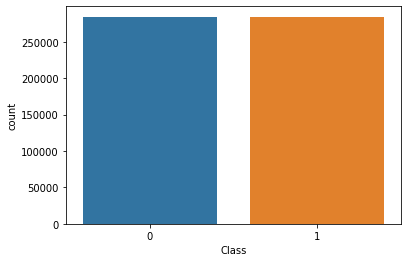

In [0]:

# Análise do balanceamento do Target
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dados.groupBy('Class').count().show()
pdf = dados.toPandas()


sns.countplot(x='Class', data=pdf)
plt.show()

> A classe alvo binária do conjunto de dados encontra-se perfeitamente balanceada. Portanto, não será necessário o uso de técnicas de balanceamento.

#### Exclusão de colunas desnecessárias 
<br>

> A variável id é responsável por identificar cada uma das transações nos dados mas não possui qualquer serventia prática no contexto de aplicação de modelos para predição de "Class", podendo inclusive causar confusões ao modelo. Desta forma, optarei pela exclusão de ID.

<br>

> Por fim, a variável "Amount" será normalizada mais adiante quando da aplicação da Regressão Logística.

In [0]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nullab

In [0]:
dados = dados.drop('id')

## ETAPA DE DESENVOLVIMENTO, APLICAÇÃO E AVALIAÇÃO DOS MODELOS DE MACHINE LEARNING COM USO DO PySparkML:

> 

> Como primeira medida antes da modelagem, farei uma cópia do data set que foi limpo e organizado nos passos anteriores, a qual chamarei df_model e será utilizada com input para treino e teste do modelo. 

<br>

> Ademais, realizarei o split dos dados em Treino e Teste antes de aplicar qualquer transformação às colunas que serão utilizadas, como por exemplo o StandardScaler que deve se aplicado à coluna Amount.

<br>

> Farei desta forma para evitar qualquer tipo de vazamento de dados (Data Leakage) que possa influenciar no resultado final do modelo e levar a um possível overfitting, o que prejudicaria a capacidade de generalização do modelo.

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

df_model = dados

# split dos dados
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=12345)


> Um adendo aqui diz respeito à seguinte questão: A coluna Amount será padronizada via StandardScaler para que tenha média = 0 e Desvio padrão = 1, assim como as demais variáveis explicativas. Apesar de não haver necessidade de realizar este procedimento neste momento por estarmos a aplicar em primeira instância um modelo em árvore, que naturalemente não possui sensibilidade à escala das variáveis, isto não faria qualquer diferenca neste contexto.

<br>

> Entretanto, testarei mais adiante a aplicação de outros modelos baseados em gradiente, como é o caso da Regressão Logística, e para tanto será necessário que as variáveis estejam padronizadas.

In [0]:
## list compreheension para guardar todas as vars explicativas e posteriormente transforma-las em vector p/ modelo
feature_columns = [col for col in df_model.columns if col != "Class"]

# 1 - transformar a coluna 'Amount' em um vector e passar o standardscaler
amount_assembler = VectorAssembler(inputCols=["Amount"], outputCol="amount_vec")
scaler = StandardScaler(inputCol="amount_vec", outputCol="scaled_amount", withStd=True, withMean=True)

# VectorAssembler para todas as vars explicativas do modelo
final_assembler = VectorAssembler(inputCols=["scaled_amount"] + feature_columns, outputCol="features")

# Configurar o RF
rf = RandomForestClassifier(featuresCol="features", 
                            labelCol="Class", 
                            numTrees=100,
                            maxDepth=5,
                            impurity="gini",
                            seed=12345)

# Criar o Pipeline
pipeline = Pipeline(stages=[amount_assembler, scaler, final_assembler, rf])
pipeline_model = pipeline.fit(train_data)

#fazer preds
predictions = pipeline_model.transform(test_data)

#avaliar 
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.9893607598167644


> O ROC e Accuracy estão muito altos. Com métricas de acerto acima dos 90%, como é o caso, é necessário investigar se não há overfitting e o quão capaz de generalizar o modelo é.

<br>

> Apesar de o random forest ser um modelo que tradicionalmente evita o overfitting, é necessário aplicar a validação cruzada para saber se as métricas após a validação cruzada ficarão ao menos próximas das que foram encontradas. 

### Aplicação da Validação Cruzada com k_folds = 3 ao modelo Random Forests:

In [0]:
from pyspark.ml.tuning import CrossValidator

# add o cv sem griid search momentaneamente
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=[{}],  # GRID SEARCH só será utilizado na proxima etapa de RL
                          evaluator=evaluator,
                          numFolds=3)

#fit do modelo ao CV
cv_model = crossval.fit(train_data)

# previsoes apos add da valid. cruzada
predictions2 = cv_model.transform(test_data)

#avaliar o modelo
roc_auc_rf_cv = evaluator.evaluate(predictions2)
print(f"ROC AUC: {roc_auc_rf_cv}")

ROC AUC: 0.9893598815862853


> Nota-se que após a aplicação da validação cruzada o modelo apresentou um desempenho ainda melhor, demonstrando que é um bom modelo e tem uma capacidade sofisticada de prever a variável-alvo.

> Por conseguinte, ainda que o random Forest tenha se mostrado como uma opção confiável e com alta capacidade preditiva, aplicarei a seguir um modelo de Regressão Logística aos dados, com vistas a perceber se o desempenho será ainda melhor que o de seu predecessor.

In [0]:
#output do modo como as predicoes sao feitas pelo modelo
predictions.select("Class", "prediction", "probability").show()

+-----+----------+--------------------+
|Class|prediction|         probability|
+-----+----------+--------------------+
|    0|       1.0|[0.00220516195352...|
|    0|       0.0|[0.71049203486937...|
|    0|       0.0|[0.75494453216849...|
|    0|       0.0|[0.62938142528624...|
|    0|       0.0|[0.79084623392165...|
|    1|       1.0|[0.00220516195352...|
|    1|       1.0|[0.00220516195352...|
|    0|       0.0|[0.85104404466700...|
|    0|       0.0|[0.88456024073073...|
|    0|       1.0|[0.00220516195352...|
|    0|       0.0|[0.83219214426668...|
|    0|       0.0|[0.76651675421502...|
|    0|       1.0|[0.00220516195352...|
|    0|       0.0|[0.77758038362125...|
|    0|       0.0|[0.77201776451890...|
|    0|       0.0|[0.75584884335784...|
|    0|       0.0|[0.81965853428415...|
|    0|       0.0|[0.79867329071157...|
|    1|       1.0|[0.00221767990677...|
|    0|       0.0|[0.77475731186917...|
+-----+----------+--------------------+
only showing top 20 rows



In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder

# instanciar a Regressão Logística
lr = LogisticRegression(featuresCol="features", 
                        labelCol="Class",
                        maxIter=100)

# pipeline 
pipeline_rl = Pipeline(stages=[amount_assembler, scaler, final_assembler, lr])

# add o Grid Search em busca dos melhores hiperparametros
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# aplicar cv tambem à Reg. Logistica p/ evitar overfitting, ja que RL é mais sensivel ao overfitting que o Random Forest.
crossval_rl = CrossValidator(estimator=pipeline_rl,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)


# modelo de RL + CV
cv_model_rl = crossval_rl.fit(train_data)
predictions3 = cv_model_rl.transform(test_data)

# avaliar usando mesma métrica dos anteriores
roc_auc_rl = evaluator.evaluate(predictions3)
print(f"ROC AUC: {roc_auc_rl}")


ROC AUC: 0.9920507354480571


> Há aqui uma acurácia ainda mais alta que no modelo anterior, o que comprova que provavelmente a Regressão Logística é o modelo que melhor se aplica aos dados ora propostos.

<br>

> Há entretanto um lado negativo que diz respeito à performance: Mesmo Trabalhando em spark, o modelo levou aproximadamente 16 minutos para ser treinado, ante os 10 minutos do random forest + validação cruzada. Em um ambiente de produção, a depender da tarefa e dos objetivos, pode ser que seja difícil operacionalizar o uso deste modelo, o que não significa dizer que ele é ruim.

<br>

> Testarei a seguir uma árvore de decisão, vez que esta é mais simples que os demais e, aparentemente, tende a ser mais rápida. O objetivo é saber se haverá queda no tempo de treinemnto do modelo e sobretudo na métrica de avaliação.

### Modelo 3: Decision Tree para Classificação.

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

# instanciar o modelo dt
dt = DecisionTreeClassifier(featuresCol="features", 
                            labelCol="Class")

# criar pipe proprio
pipeline_dt = Pipeline(stages=[amount_assembler, scaler, final_assembler, dt])

# grid serach para maxbins e maxdepth
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 30, 40]) \
    .build()

# evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# configurar cv para dt
crossval_dt = CrossValidator(estimator=pipeline_dt,
                             estimatorParamMaps=paramGrid,
                             evaluator=evaluator,
                             numFolds=3)

# modelo + cv
cv_model_dt = crossval_dt.fit(train_data)

predictions_dt = cv_model_dt.transform(test_data)

# avaliar
roc_auc_dt = evaluator.evaluate(predictions_dt)
print(f"ROC AUC (Decision Tree): {roc_auc_dt}")

ROC AUC (Decision Tree): 0.9993357194556867


> Conforme demonstrado, o tempo de execução para a árvore de decisão também foi relativamente alto. Entretanto, o modelo mostrou-se ainda mais eficiente que os demais e apresentou um ROC de 0.999.

<br>

> Provavelmente existe pouco ruído/variância nos dados e por conta disso os modelos tem conseguido captar quase que na totalidade as nuances das classes.

<br>

> Quanto ao tempo de execução, é natural que seja mais alto por conta das etapas de validação cruzada e grid search, onde é necessário realizar uma série de iterações nos dados, o que onera sobremaneira o cluster spark criado.

## Visualização agrupada do desempenho dos modelos:

> Neste ponto fica demonstrada a comparação entre as métricas de avaliação dos modelos de modo a perceber qual apresentou o valor mais elevado de ROC, a saber:

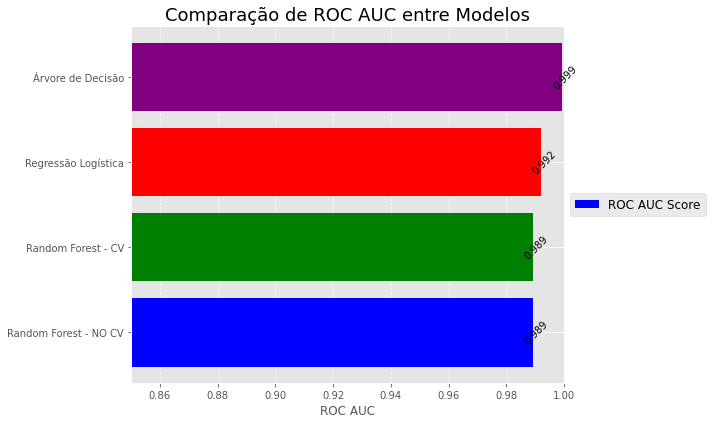

In [0]:
import matplotlib.pyplot as plt

#nomes dos modelos e suas métricas ROC AUC
model_names = ['Random Forest - NO CV', 'Random Forest - CV', 'Regressão Logística', 'Árvore de Decisão']
roc_auc_scores = [roc_auc, roc_auc_rf_cv, roc_auc_rl, roc_auc_dt]

colors = ['blue', 'green', 'red', 'purple']

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, roc_auc_scores, color=colors)

for bar, score in zip(bars, roc_auc_scores):
    plt.text(bar.get_width() + 0.001,  # Posição do texto
             bar.get_y() + bar.get_height() / 2, 
             f'{score:.3f}', 
             ha='center', va='center', fontsize=10, rotation=45)

plt.xlim(0.85, 1.0)
plt.xlabel('ROC AUC')
plt.title('Comparação de ROC AUC entre Modelos', fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(['ROC AUC Score'], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

